In [2]:
import os
os.chdir('../')
import model.op
from model.op import FleetSizeOptimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
kappa = np.array([[0, 41.58, 35.88],[37.31, 0, 28.51], [27.77, 25.67, 0]])/160*100
tau = np.array([[0, 18.71, 15.48], [19.43, 0, 12.45], [9.74, 5.70, 0]])+5

kappa = kappa[0:2,0:2]
tau = tau[0:2,0:2]
op = FleetSizeOptimizer(flight_time=tau, energy_consumption=kappa, schedule='schedule_5min_0612.csv')

In [4]:
name = 'test2'
op.optimize(f'HHR_WARNER/{name}.txt', charging_station=[True, True], number_of_pads=[18,18])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-29
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 22288 rows, 349272 columns and 2548156 nonzeros
Model fingerprint: 0xc0167787
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 1904 rows and 5700 columns
Presolve time: 1.97s
Presolved: 20384 rows, 343572 columns, 2515840 nonzeros
Variable types: 0 continuous, 343572 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.81s

Barrier statistic

AttributeError: Unable to retrieve attribute 'x'

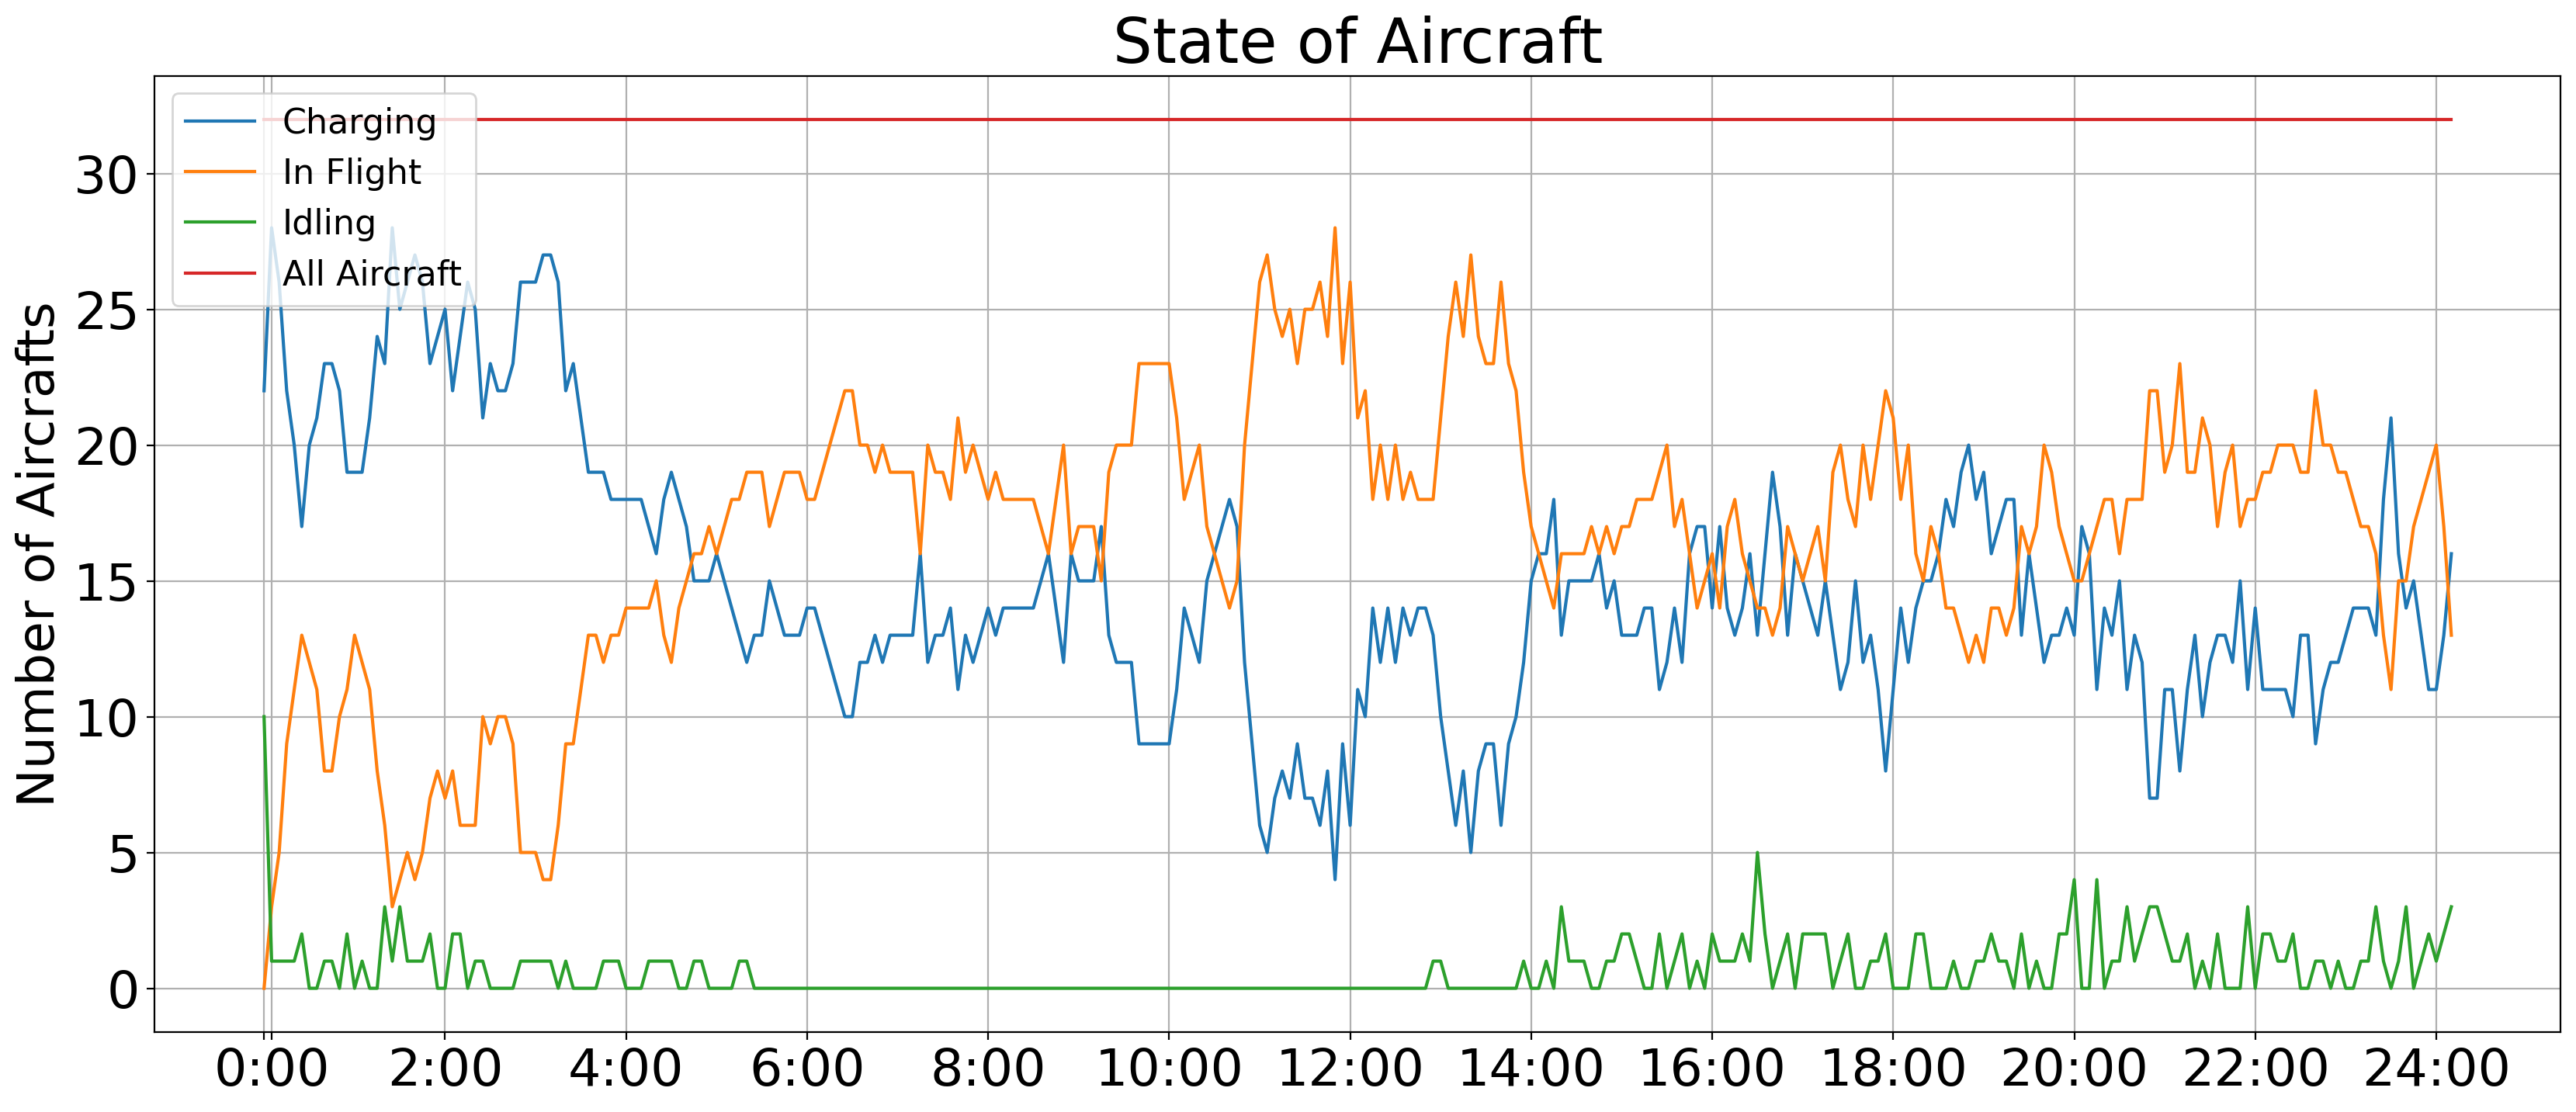

In [15]:
op.parse_result(f'HHR_WARNER/{name}.txt')
op.calculate_aircraft_states()
op.plot_aircraft_state() 

In [18]:
dist = np.array([[0, 53.23, 38.80], [60.36, 0, 31.90], [26.21, 9.26, 0]])/1.6
dist = dist[0:2,0:2]
op.get_summary_statistics(dist)

Fleet size: 32.0
Total number of pads: 32; [14 18] 
Total number of flights: 972.0; demand: 771.0; repositioning: 201.0
Total energy consumption: 10206.0 kWh
Total aircraft miles: 34502.962499999994 mi
Total revenue aircraft miles: 27383.687499999996
Ratio of revenue aircraft miles to aircraft miles: 0.7936619210596771


## Testing

In [51]:
c, u, n = op.calculate_aircraft_states(idx=1)

In [52]:
c.sum(axis=0) + n.sum(axis=0)

array([18., 16., 15., 13., 12., 11., 12., 13., 15., 15., 14., 14., 13.,
       14., 15., 17., 17., 18., 18., 17., 18., 18., 16., 16., 16., 16.,
       18., 17., 16., 14., 15., 15., 15., 15., 17., 17., 17., 18., 18.,
       18., 17., 17., 17., 16., 17., 18., 18., 18., 17., 18., 18., 18.,
       17., 17., 18., 18., 17., 16., 16., 15., 16., 15., 14., 14., 13.,
       13., 13., 15., 14., 13., 13., 13., 14., 13., 13., 12., 11., 10.,
       10., 12., 12., 12., 11., 13., 13., 13., 13., 14., 12., 13., 13.,
       14., 11., 12., 12., 13., 14., 13., 14., 14., 14., 14., 14., 14.,
       14., 13., 12., 13., 12., 12., 13., 14., 12., 11., 11., 10.,  7.,
        8.,  9.,  9.,  9.,  8., 10., 10., 10., 13., 12., 12., 12., 12.,
       10.,  8.,  6.,  5.,  7.,  8.,  7.,  7.,  5.,  5.,  4.,  3.,  1.,
        3.,  2.,  4.,  3.,  5.,  5.,  6.,  6.,  8.,  7.,  8.,  6.,  7.,
        6.,  6.,  4.,  5.,  3.,  4.,  6.,  5.,  3.,  4.,  4.,  5.,  5.,
        5.,  5.,  6.,  5.,  5.,  6.,  5.,  5.,  6.,  6.,  6.,  6

In [53]:
a,b,c = op.__getVars__()
c = c - 1

In [54]:
checkc = op.specificc
checkn = op.specificn

In [56]:
for t in range(10):
    idle = checkn[(checkn['i'] == 1) & (checkn['t'] == t)]['amount'].sum()
    charging = 0
    for i in range(len(a)):
        col = a[i]
        row = b[i]

        for t_adj in range(int(t-c[col, row]), t):
            val = checkc[(checkc['i'] == 1) & (checkc['t'] == t_adj) & (checkc['x'] == col) & (checkc['y'] == row)]['amount'].sum()
            if val > 0:
                charging += val
            
                # print(t_adj, col, row, 'Number of charging', val)

    commit_to_charge = checkc[(checkc['i'] == 1) & (checkc['t'] == t)]['amount'].sum()
    print(idle + charging +commit_to_charge)
    print(idle, charging, commit_to_charge)

18.0
8.0 0 10.0
16.0
0.0 9.0 7.0
15.0
1.0 10.0 4.0
13.0
1.0 8.0 4.0
12.0
0.0 8.0 4.0
11.0
1.0 10.0 0.0
12.0
0.0 10.0 2.0
13.0
0.0 12.0 1.0
15.0
1.0 12.0 2.0
15.0
1.0 9.0 5.0


# Wind Variation

In [2]:
from tqdm import tqdm

In [3]:
hhr_warner_energy = pd.read_csv('input/route_profile/hhr_warner_energy.csv').to_numpy()[:,1:]
warner_hhr_energy = pd.read_csv('input/route_profile/warner_hhr_energy.csv').to_numpy()[:,1:]
warner_hhr_flight_duration = pd.read_csv('input/route_profile/warner_hhr_flight_duration.csv').to_numpy()[:,1:]
hhr_warner_flight_duration = pd.read_csv('input/route_profile/hhr_warner_flight_duration.csv').to_numpy()[:,1:]

In [25]:
files = os.listdir('output/HHR_WARNER/wind_variation')
files = [file.split('_')[1]+file.split('_')[3] for file in files]

In [26]:
mag = np.arange(0, 60, 10)
angel = np.arange(0, 360+45, 45)
dist = np.array([[0,30],[30,0]])
fleetsize_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))
num_pads_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))
vertiport_pads_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1], 2))
num_flight_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))
energy_consumption_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))
aircraft_miles_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))
revenue_miles_all = np.zeros((hhr_warner_energy.shape[0], hhr_warner_energy.shape[1]))


for i in tqdm(range(hhr_warner_energy.shape[0])):
    for j in range(hhr_warner_energy.shape[1]):

        if f'mag_{mag[i]}_ang_{angel[j]}.txt' in files:
            continue
        else:
            kappa = np.array([[0, hhr_warner_energy[i,j]], [warner_hhr_energy[i,j], 0]])/160*100
            tau = np.array([[0, hhr_warner_flight_duration[i,j]], [warner_hhr_flight_duration[i,j], 0]])
            op = FleetSizeOptimizer(flight_time=tau, energy_consumption=kappa, schedule='schedule_5min_0612.csv')
            op.optimize(f'HHR_WARNER/wind_variation/mag_{mag[i]}_ang_{angel[j]}.txt', charging_station=[True, True])
            op.parse_result(f'HHR_WARNER/wind_variation/mag_{mag[i]}_ang_{angel[j]}.txt')
            op.calculate_aircraft_states()

            fleetsize, num_pads, vertiport_pads, num_flight, energy_consumption, aircraft_miles, revenue_miles = op.get_summary_statistics(dist, True)

            fleetsize_all[i,j] = fleetsize
            num_pads_all[i,j] = num_pads
            vertiport_pads_all[i,j,:] = vertiport_pads
            num_flight_all[i,j] = num_flight
            energy_consumption_all[i,j] = energy_consumption
            aircraft_miles_all[i,j] = aircraft_miles
            revenue_miles_all[i,j] = revenue_miles




  0%|          | 0/6 [00:00<?, ?it/s]

Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 705872 nonzeros
Model fingerprint: 0x2c5697e1
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7487 columns
Presolve time: 0.59s
Presolved: 19762 rows, 341785 columns, 692513 nonzeros
Variable types: 0 continuous, 341785 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.49s

Barrier statistics:
 AA' NZ     : 3.608e+05
 Factor NZ  : 8.409e+06 (roughly 200 MB of memory)
 Factor Ops : 5.

 17%|█▋        | 1/6 [15:34<1:17:54, 934.94s/it]

Fleet size: 33.0
Total number of pads: 41; [14 27] 
Total number of flights: 958.0; demand: 771.0; repositioning: 187.0
Total energy consumption: 11496.0 kWh
Total aircraft miles: 28740.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8048016701461378
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 705872 nonzeros
Model fingerprint: 0x2c5697e1
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7487 columns
Presolve time: 0.57s
Presolved: 19762 rows, 341785 columns, 692513 nonzeros
Variable types: 0 continuous, 341785 integer (0 binary)
Det

 33%|███▎      | 2/6 [36:07<1:13:59, 1109.90s/it]

Fleet size: 33.0
Total number of pads: 41; [14 27] 
Total number of flights: 958.0; demand: 771.0; repositioning: 187.0
Total energy consumption: 11496.0 kWh
Total aircraft miles: 28740.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8048016701461378
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 706160 nonzeros
Model fingerprint: 0x8c2bf8fa
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7483 columns
Presolve time: 0.60s
Presolved: 19762 rows, 341789 columns, 692805 nonzeros
Variable types: 0 continuous, 341789 integer (0 binary)
Det

 50%|█████     | 3/6 [1:01:29<1:04:55, 1298.35s/it]

Fleet size: 30.0
Total number of pads: 40; [12 28] 
Total number of flights: 898.0; demand: 771.0; repositioning: 127.0
Total energy consumption: 10327.0 kWh
Total aircraft miles: 26940.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8585746102449888
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 705872 nonzeros
Model fingerprint: 0x83f191c3
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7484 columns
Presolve time: 0.57s
Presolved: 19762 rows, 341788 columns, 692516 nonzeros
Variable types: 0 continuous, 341788 integer (0 binary)
Det

 67%|██████▋   | 4/6 [1:27:01<46:20, 1390.48s/it]  

Fleet size: 31.0
Total number of pads: 44; [15 29] 
Total number of flights: 894.0; demand: 771.0; repositioning: 123.0
Total energy consumption: 10728.0 kWh
Total aircraft miles: 26820.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8624161073825504
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 705872 nonzeros
Model fingerprint: 0x83f191c3
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7484 columns
Presolve time: 0.56s
Presolved: 19762 rows, 341788 columns, 692516 nonzeros
Variable types: 0 continuous, 341788 integer (0 binary)
Det

 83%|████████▎ | 5/6 [1:47:15<22:06, 1326.84s/it]

Fleet size: 31.0
Total number of pads: 44; [15 29] 
Total number of flights: 894.0; demand: 771.0; repositioning: 123.0
Total energy consumption: 10728.0 kWh
Total aircraft miles: 26820.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8624161073825504
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 21700 rows, 349272 columns and 705584 nonzeros
Model fingerprint: 0xd4ad1026
Variable types: 0 continuous, 349272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1938 rows and 7485 columns
Presolve time: 0.61s
Presolved: 19762 rows, 341787 columns, 692227 nonzeros
Variable types: 0 continuous, 341787 integer (0 binary)
Det

100%|██████████| 6/6 [2:04:00<00:00, 1240.09s/it]

Fleet size: 31.0
Total number of pads: 43; [14 29] 
Total number of flights: 888.0; demand: 771.0; repositioning: 117.0
Total energy consumption: 11100.0 kWh
Total aircraft miles: 26640.0 mi
Ratio of revenue aircraft miles to aircraft miles: 0.8682432432432432


In [4]:
import numpy as np
soc_transition_time = np.array([0.0129,0.0133,0.0137,0.0142,0.0147,
                                0.0153,0.0158,0.0166,0.0172,0.018,
                                0.0188,0.0197,0.0207,0.0219,0.0231,
                                0.0245,0.026,0.0278,0.03,0.0323,
                                0.0351,0.0384,0.0423,0.0472,0.0536,
                                0.0617,0.0726,0.0887,0.1136,0.1582,
                                0.2622,0.9278,])*60

In [5]:
w = np.zeros(shape=(len(soc_transition_time), len(soc_transition_time)))
for i in range(len(soc_transition_time)):
    for j in range(1, len(soc_transition_time)):
        w[i,j] = soc_transition_time[i:j].sum()

In [6]:
w = w // 5 + 1

In [7]:
row, col = np.where(w>1)

1.0

In [9]:
w[6,6]

1.0

In [19]:
row

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10

In [20]:
col

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 15, 16,
       17, 18, 19, 20, 21